In [1]:
#importing useful libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy.stats import zscore
import seaborn as sns


In [2]:
#load data
df=pd.read_csv("card-win-rates-2020-11-08.csv")

In [3]:
#take only games where neither player mulliganed
clean_games=df[df['num_mulligans'] + df['opp_num_mulligans']==0].reset_index(drop=True)
clean_games

,draft_time,expansion,event_type,game_number,rank,on_play,num_mulligans,opp_num_mulligans,opp_colors,num_turns,...,deck_Veteran Adventurer,deck_Vine Gecko,deck_Wayward Guide-Beast,deck_Windrider Wizard,"deck_Yasharn, Implacable Earth","deck_Zagras, Thief of Heartbeats","deck_Zareth San, the Trickster",deck_Zof Bloodbog,deck_Zof Consumption,deck_Zulaport Duelist
0,2020-11-06 05:21:02,ZNR,PremierDraft,1,Gold-2-0-0-4,False,0,0,RG,8,...,0,0,0,0,0,0,0,0,0,0
1,2020-11-06 05:21:02,ZNR,PremierDraft,1,Gold-2-0-0-3,False,0,0,WU,13,...,0,0,0,0,0,0,0,0,0,0
2,2020-11-06 05:21:02,ZNR,PremierDraft,1,Gold-1-0-0-0,True,0,0,WU,10,...,0,0,0,0,0,0,0,0,0,0
3,2020-11-06 05:21:02,ZNR,PremierDraft,1,Gold-1-0-0-2,True,0,0,WG,7,...,0,0,0,0,0,0,0,0,0,0
4,2020-10-30 03:57:45,ZNR,PremierDraft,1,Platinum-1-0-0-0,True,0,0,UB,9,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68381,2020-10-03 14:45:29,ZNR,PremierDraft,1,Gold-1-0-0-2,True,0,0,WB,8,...,1,0,0,0,0,0,0,0,0,0
68382,2020-10-03 14:45:29,ZNR,PremierDraft,1,Gold-1-0-0-4,True,0,0,WUB,9,...,1,0,0,0,0,0,0,0,0,0
68383,2020-10-03 14:45:29,ZNR,PremierDraft,1,Platinum-4-0-0-1,True,0,0,UB,21,...,1,0,0,0,0,0,0,0,0,0
68384,2020-10-03 14:45:29,ZNR,PremierDraft,1,Platinum-4-0-0-2,True,0,0,UB,13,...,1,0,0,0,0,0,0,0,0,0


In [4]:
#looking at just basic lands
lands=clean_games[['deck_Plains','deck_Island','deck_Swamp','deck_Mountain','deck_Forest']]

In [5]:
#look at just deck inclusions
clean_deck=clean_games.iloc[:,623:928]

In [6]:
#creating a method that labels decks in a rule based fashion based on land counts
def classify_deck (row):
    #this variable can be fine tuned to account for how many splashes of a third color you want to allow in a 2 color deck
    _splash_count=0
    #label the deck jank as a default
    _deck='jank'
    #decks with 12 or more of a basic are considered mono color
    if (row['deck_Plains']>11):
        _deck='Mono W'
    elif (row['deck_Island']>11):
        _deck='Mono U'
    elif (row['deck_Swamp']>11):
        _deck='Mono B' 
    elif (row['deck_Mountain']>11):
        _deck='Mono R'
    elif (row['deck_Forest']>11):
        _deck='Mono G'
    #now assign decks by two color pair. The _splash_count variable can be adjusted up top
    elif (row['deck_Plains']>4 and row['deck_Island']>4 and math.sqrt(row['deck_Swamp']**2+row['deck_Mountain']**2+row['deck_Forest']**2)<=_splash_count):
        _deck='WU'
    elif (row['deck_Plains']>4 and row['deck_Swamp']>4 and math.sqrt(row['deck_Island']**2+row['deck_Mountain']**2+row['deck_Forest']**2)<=_splash_count):
        _deck='WB'
    elif (row['deck_Plains']>4 and row['deck_Mountain']>4 and math.sqrt(row['deck_Swamp']**2+row['deck_Island']**2+row['deck_Forest']**2)<=_splash_count):
        _deck='WR'
    elif (row['deck_Plains']>4 and row['deck_Forest']>4 and math.sqrt(row['deck_Swamp']**2+row['deck_Mountain']**2+row['deck_Island']**2)<=_splash_count):
        _deck='WG'
    elif (row['deck_Island']>4 and row['deck_Swamp']>4 and math.sqrt(row['deck_Plains']**2+row['deck_Mountain']**2+row['deck_Forest']**2)<=_splash_count):
        _deck='UB'
    elif (row['deck_Island']>4 and row['deck_Mountain']>4 and math.sqrt(row['deck_Swamp']**2+row['deck_Plains']**2+row['deck_Forest']**2)<=_splash_count):
        _deck='UR'
    elif (row['deck_Island']>4 and row['deck_Forest']>4 and math.sqrt(row['deck_Swamp']**2+row['deck_Mountain']**2+row['deck_Plains']**2)<=_splash_count):
        _deck='UG'
    elif (row['deck_Swamp']>4 and row['deck_Mountain']>4 and math.sqrt(row['deck_Island']**2+row['deck_Plains']**2+row['deck_Forest']**2)<=_splash_count):
        _deck='BR'
    elif (row['deck_Swamp']>4 and row['deck_Forest']>4 and math.sqrt(row['deck_Island']**2+row['deck_Mountain']**2+row['deck_Plains']**2)<=_splash_count):
        _deck='BG'
    elif (row['deck_Mountain']>4 and row['deck_Forest']>4 and math.sqrt(row['deck_Swamp']**2+row['deck_Island']**2+row['deck_Plains']**2)<=_splash_count):
        _deck='RG'
        #now look at 3 color decks
    elif (row['deck_Plains'] + row['deck_Island'] + row['deck_Swamp']>11):
        _deck='WUB'
    elif (row['deck_Plains'] + row['deck_Island'] + row['deck_Mountain']>11):
        _deck='WUR'
    elif (row['deck_Plains'] + row['deck_Island'] + row['deck_Forest']>11):
        _deck='WUG'
    elif (row['deck_Plains'] + row['deck_Swamp'] + row['deck_Mountain']>11):
        _deck='WBR'
    elif (row['deck_Plains'] + row['deck_Swamp'] + row['deck_Forest']>11):
        _deck='WBG'
    elif (row['deck_Plains'] + row['deck_Mountain'] + row['deck_Forest']>11):
        _deck='WRG'
    elif (row['deck_Island'] + row['deck_Swamp'] + row['deck_Mountain']>11):
        _deck='UBR'
    elif (row['deck_Island'] + row['deck_Mountain'] + row['deck_Forest']>11):
        _deck='URG'
    elif (row['deck_Island'] + row['deck_Swamp'] + row['deck_Forest']>11):
        _deck='UBG'
    elif (row['deck_Swamp'] + row['deck_Mountain'] + row['deck_Forest']>11):
        _deck='BRG'
    return _deck

In [7]:
#cluster decks based on basic lands
cluster_names=lands.apply(lambda row: classify_deck(row), axis=1)

In [8]:
#add names to dataframe
lands['names']=cluster_names
#get count of decks by color combination
cluster_names.value_counts()

<ipython-input-8-f1ed3324efbe>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lands['names']=cluster_names


WB        8517
UB        8179
UR        7900
WR        7895
BR        7776
UG        5940
WUG       3825
WU        3510
RG        2751
BG        2557
WUB       1921
WG        1903
WUR       1278
WRG       1172
WBG       1020
WBR        720
jank       317
URG        300
UBG        232
BRG        172
UBR        158
Mono U     147
Mono R     122
Mono G      55
Mono W      13
Mono B       6
dtype: int64

In [9]:
#cleaning up the column names
clean_deck
new_col_names=[]
for name in clean_deck.columns:
    new_col_names.append(name[5:])
clean_deck.columns=new_col_names
clean_deck

,Acquisitions Expert,Adventure Awaits,Agadeem's Awakening,"Agadeem, the Undercrypt","Akiri, Fearless Voyager",Akoum Hellhound,Akoum Teeth,Akoum Warrior,Allied Assault,Ancient Greenwarden,...,"Verazol, the Split Current",Veteran Adventurer,Vine Gecko,Wayward Guide-Beast,Windrider Wizard,"Yasharn, Implacable Earth","Zagras, Thief of Heartbeats","Zareth San, the Trickster",Zof Bloodbog,Zof Consumption
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68381,0,0,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
68382,0,0,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
68383,0,0,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
68384,0,0,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0


In [10]:
clean_deck['deck_type']=cluster_names
#need to add whether or not the deck won into the decklist
clean_deck['won']=clean_games['won']
#checking
clean_deck.head()

,Acquisitions Expert,Adventure Awaits,Agadeem's Awakening,"Agadeem, the Undercrypt","Akiri, Fearless Voyager",Akoum Hellhound,Akoum Teeth,Akoum Warrior,Allied Assault,Ancient Greenwarden,...,Vine Gecko,Wayward Guide-Beast,Windrider Wizard,"Yasharn, Implacable Earth","Zagras, Thief of Heartbeats","Zareth San, the Trickster",Zof Bloodbog,Zof Consumption,deck_type,won
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,BR,False
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,BR,True
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,BR,False
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,BR,False
4,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,UG,False


In [11]:
#selecting just 2 color combinations
list_of_decks=['WB','UB','UR','WR','BR','UG','WU','RG','BG','WG']

In [12]:
#This cell will separate out each of the listed decks, z-score the cards included by deck, separate winning and losing
#decks, then subtract the losses from the wins. Finally it will create a dataframe of results

#use this to store results
results_list=[]

for i,deck in enumerate(list_of_decks):
    #grab only the selected deck
    temp_deck=clean_deck[clean_deck['deck_type']==deck]
    #apply z-score to all but 'won' and 'deck_name'
    temp_deck.iloc[:,:-2]=temp_deck.iloc[:,:-2].apply(zscore)
    #separate wins and losses
    temp_wins=temp_deck[temp_deck['won']==True]
    temp_losses=temp_deck[temp_deck['won']==False]
    #subtract the z-scores of losses from wins.
    diff=temp_wins.iloc[:,:-2].mean(axis=0)-temp_losses.iloc[:,:-2].mean(axis=0)
    #store the result
    results_list.append(diff)
#make the result a dataframe
results=pd.DataFrame(results_list)
#add the deck name in and set it as index
results['deck']=pd.Series(list_of_decks)
results=results.set_index('deck')
#drop any rows of all missing values. Necessary for MDCs
results=results.dropna(axis=1,how="all")
#round the z-scores to 3 decimal places
results=results.round(3)

C:\Users\gamui\anaconda3\lib\site-packages\scipy\stats\stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd
C:\Users\gamui\anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [13]:
# # do some dataframe styling

# def color_code(val):
#     """
#     Takes a scalar and returns a string with
#     the css property `'color: red'` for negative
#     strings, black otherwise.
#     """
     
#     if val < -0.1:
#         color = 'red'
#     elif val > 0.1: 
#         color = 'green' 
#     else: 
#         color = 'black'
#     return 'color: %s' % color

# def highlight_max_min(s):
#     '''
#     highlight the maximum in a Series yellow.
#     '''
#     is_max = s == s.max()
#     is_min = s == s.min()
#     is_either = [mx or mn for mx,mn in zip(is_max,is_min)]
#     return ['background-color: yellow' if v else '' for v in is_either]

# def highlight_max(s):
#     '''
#     highlight the maximum in a Series yellow.
#     '''
#     is_max = s == s.max()
#     return ['background-color: green' if v else '' for v in is_max]

# def highlight_min(s):
#     '''
#     highlight the maximum in a Series yellow.
#     '''
#     is_min = s == s.min()
#     return ['background-color: red' if v else '' for v in is_min]

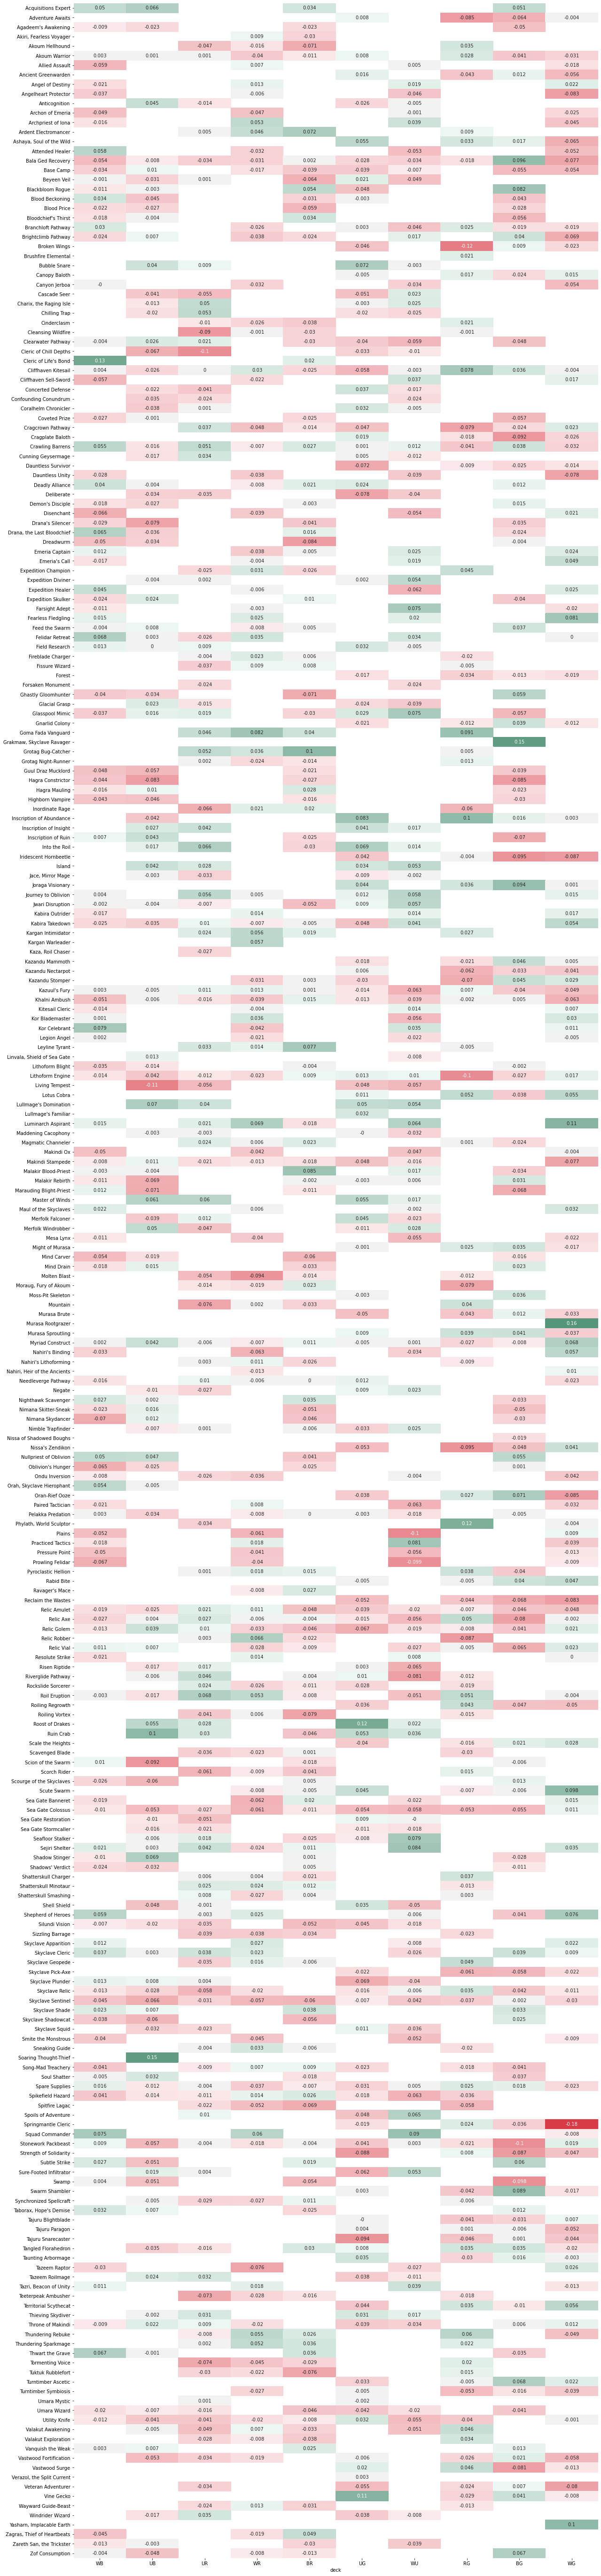

In [14]:
#Do some visualizations

#first set the figuresize to be appropriate
plt.rcParams["figure.figsize"] = (20,100)

#create a red-green diverging color palette
cm = sns.diverging_palette(10, 150, as_cmap=True)
#transpose the dataframe and apply the styling. Save to excel
s = results.T.style.background_gradient(cmap=cm)
s.to_excel("styled.xlsx")

#create a heatmap and save the figure to .png
hmap=sns.heatmap(results.T,cmap=cm,center=0,annot=True,cbar=False)
figure=hmap.get_figure()
figure.savefig('output.png')
plt.show()